In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install geopandas matplotlib requests xarray rasterio rioxarray shapely


In [13]:
# Required packages for data manipulation and visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Required for HTTP requests
import requests
from bs4 import BeautifulSoup

# Required for working with multi-dimensional arrays and netCDF files
import xarray as xr
import os

# Required for spatial data manipulation
from rasterio.features import Affine, geometry_mask
import rioxarray
from shapely.geometry import mapping
from shapely.ops import transform
import pyproj
from pyproj import CRS, Proj
from functools import partial


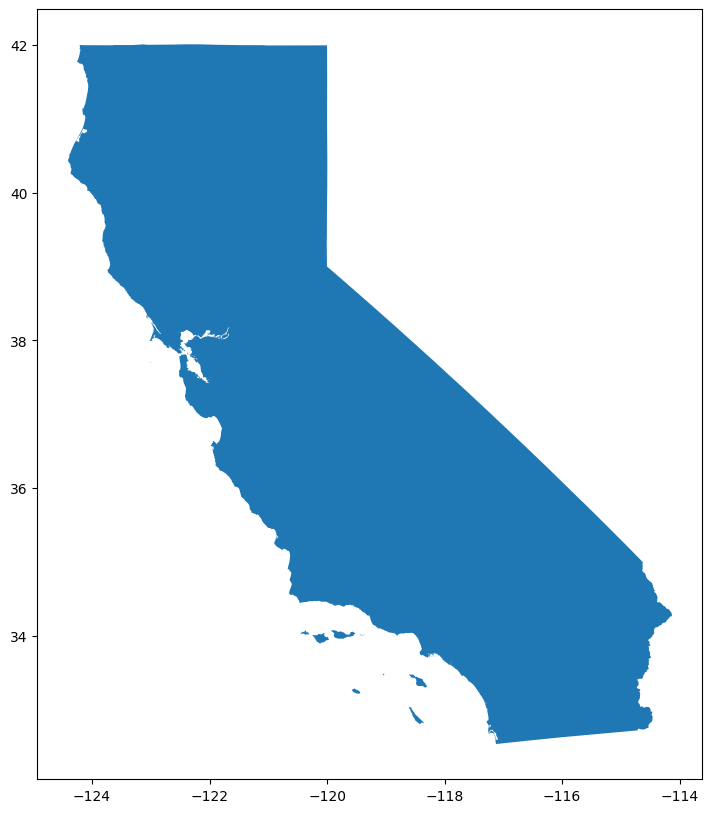

In [19]:
gdf = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_1.shp')
# Originally downloaded from:
## https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_USA_shp.zip

state = 'California'
bounding_shapefile = gdf[gdf['NAME_1'] == state]
fig, ax = plt.subplots(figsize=(10, 10))
bounding_shapefile.plot(ax=ax)
plt.show()


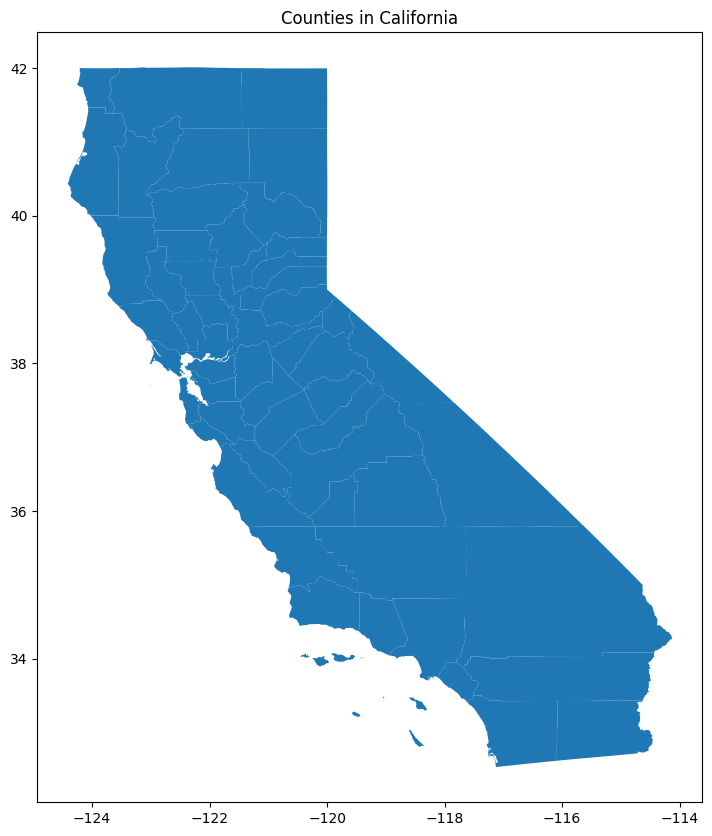

In [21]:
# Load the county-level shapefile
gdf_counties = gpd.read_file('/content/drive/MyDrive/Moths!/data/gadm41_USA_shp/gadm41_USA_2.shp')

# Filter the GeoDataFrame to include only the counties within the specified state
counties_shapefile = gdf_counties[gdf_counties['NAME_1'] == state]

# Plot the counties
fig, ax = plt.subplots(figsize=(10, 10))
counties_shapefile.plot(ax=ax)
ax.set_title(f'Counties in {state}')
plt.show()

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Extract dataset-specific links from the THREDDS Catalog. If a different catalog is desired (like daily or yearly values), this is where you would chanage that
catalog_url = 'https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html'
response = requests.get(catalog_url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find all the <a> tags with href attributes on the page and extract unique dataset options to display to user
links = soup.find_all('a', href=True)
dataset_options = set()
for link in links:
    href = link['href']
    if 'dataset=' in href and 'daymet_v4_' in href:
        dataset_name = href.split('=')[-1]
        option = dataset_name.replace('daymet_v4_', '').rsplit('_', 1)[0]
        dataset_options.add(option)
print("Available dataset options:")
for i, option in enumerate(sorted(dataset_options), start=1):
    print(f"{i}. {option}")

# Get user's choice and filter based on this choice
user_choice = int(input("Enter the number of the dataset you want to choose: ")) - 1
selected_option = sorted(dataset_options)[user_choice]
dataset_links = ['https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/2131/catalog.html?dataset=' + link['href'].split('=')[-1] for link in links if 'dataset=' in link['href'] and selected_option in link['href'].replace('daymet_v4_', '').rsplit('_', 1)[0]]

# Print selected dataset links in a readable format
df = pd.DataFrame(dataset_links, columns=['Links'])
print("\nSelected dataset links:")
print(df)


Available dataset options:
1. 2131/prcp_monttl_hi
2. 2131/prcp_monttl_na
3. 2131/prcp_monttl_pr
4. 2131/swe_monavg_hi
5. 2131/swe_monavg_na
6. 2131/swe_monavg_pr
7. 2131/tmax_monavg_hi
8. 2131/tmax_monavg_na
9. 2131/tmax_monavg_pr
10. 2131/tmin_monavg_hi
11. 2131/tmin_monavg_na
12. 2131/tmin_monavg_pr
13. 2131/vp_monavg_hi
14. 2131/vp_monavg_na
15. 2131/vp_monavg_pr
Enter the number of the dataset you want to choose: 8

Selected dataset links:
                                                Links
0   https://thredds.daac.ornl.gov/thredds/catalog/...
1   https://thredds.daac.ornl.gov/thredds/catalog/...
2   https://thredds.daac.ornl.gov/thredds/catalog/...
3   https://thredds.daac.ornl.gov/thredds/catalog/...
4   https://thredds.daac.ornl.gov/thredds/catalog/...
5   https://thredds.daac.ornl.gov/thredds/catalog/...
6   https://thredds.daac.ornl.gov/thredds/catalog/...
7   https://thredds.daac.ornl.gov/thredds/catalog/...
8   https://thredds.daac.ornl.gov/thredds/catalog/...
9   https://

In [27]:
# Base URL for the THREDDS file server, again change this if a different catalog desired
base_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/"

# Initialize an empty list to store the xarray datasets and create a directory to store the downloaded NetCDF files
datasets = []
os.makedirs('netcdf_files', exist_ok=True)

# Loop through each dataset URL
for i, data_url in enumerate(dataset_links, start=1):
    # Extract the NetCDF file name from the URL
    nc_filename = data_url.split('/')[-1].replace('catalog.html?dataset=', '')

    # Construct the direct URL to the NetCDF file
    direct_url = base_url + nc_filename

    print(f"Downloading dataset {i}/{len(dataset_links)}: {direct_url}")

    # Download the dataset
    response = requests.get(direct_url)
    if response.status_code != 200:
        print(f"Failed to download dataset {i}: HTTP status code {response.status_code}")
        continue

    filename = f'netcdf_files/{nc_filename}'

    with open(filename, 'wb') as f:
        f.write(response.content)

    # Check if the file is downloaded correctly
    file_size = os.path.getsize(filename)
    print(f"File size of dataset {i}: {file_size} bytes")
    if file_size == 0:
        print(f"Failed to download dataset {i}: The file is empty")
        continue

    # Load the dataset and add it to the list
    try:
        ds = xr.open_dataset(filename)
        datasets.append(ds)
        print(f"Dataset {i} loaded successfully")
    except Exception as e:
        print(f"Failed to load dataset {i}: {str(e)}")

print("All datasets processed.")
print(f"Number of successfully loaded datasets: {len(datasets)}")


File size of dataset 1: 982605 bytes
Dataset 1 loaded successfully
File size of dataset 2: 967933 bytes
Dataset 2 loaded successfully
File size of dataset 3: 983677 bytes
Dataset 3 loaded successfully
File size of dataset 4: 980908 bytes
Dataset 4 loaded successfully
File size of dataset 5: 981045 bytes
Dataset 5 loaded successfully
File size of dataset 6: 983679 bytes
Dataset 6 loaded successfully
File size of dataset 7: 992616 bytes
Dataset 7 loaded successfully
File size of dataset 8: 982648 bytes
Dataset 8 loaded successfully
File size of dataset 9: 988343 bytes
Dataset 9 loaded successfully
File size of dataset 10: 988629 bytes
Dataset 10 loaded successfully
File size of dataset 11: 996859 bytes
Dataset 11 loaded successfully
File size of dataset 12: 989233 bytes
Dataset 12 loaded successfully
File size of dataset 13: 986692 bytes
Dataset 13 loaded successfully
File size of dataset 14: 990969 bytes
Dataset 14 loaded successfully
File size of dataset 15: 979410 bytes
Dataset 15 loa

In [9]:
# This is for testing, it downloads only one entry

# Base URL for the THREDDS file server
base_url = "https://thredds.daac.ornl.gov/thredds/fileServer/ornldaac/2131/"

# Initialize an empty list to store the xarray datasets and create a directory to store the downloaded NetCDF files
datasets = []
os.makedirs('netcdf_files', exist_ok=True)

# To save time while testing, extract the first dataset URL from the DataFrame
data_url = df.loc[0, 'Links']

# Extract the NetCDF file name from the URL
nc_filename = data_url.split('/')[-1].replace('catalog.html?dataset=', '')

# Construct the direct URL to the NetCDF file
direct_url = base_url + nc_filename

print(f"Downloading dataset: {direct_url}")

# Download the dataset
response = requests.get(direct_url)
if response.status_code == 200:
    filename = f'netcdf_files/{nc_filename}'

    with open(filename, 'wb') as f:
        f.write(response.content)

    # Check if the file is downloaded correctly
    file_size = os.path.getsize(filename)
    print(f"File size of dataset: {file_size} bytes")
    if file_size > 0:
        # Load the dataset and add it to the list
        try:
            ds = xr.open_dataset(filename)
            datasets.append(ds)
            print("Dataset loaded successfully")
        except Exception as e:
            print(f"Failed to load dataset: {str(e)}")
    else:
        print("Failed to download dataset: The file is empty")
else:
    print(f"Failed to download dataset: HTTP status code {response.status_code}")

print("All datasets processed.")
print(f"Number of successfully loaded datasets: {len(datasets)}")


File size of dataset: 1112188165 bytes
Dataset loaded successfully
All datasets processed.
Number of successfully loaded datasets: 1


<xarray.Dataset>
Dimensions:                  (time: 12, nv: 2, y: 8075, x: 7814)
Coordinates:
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 1980-01-16T12:00:00 ... 19...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current info

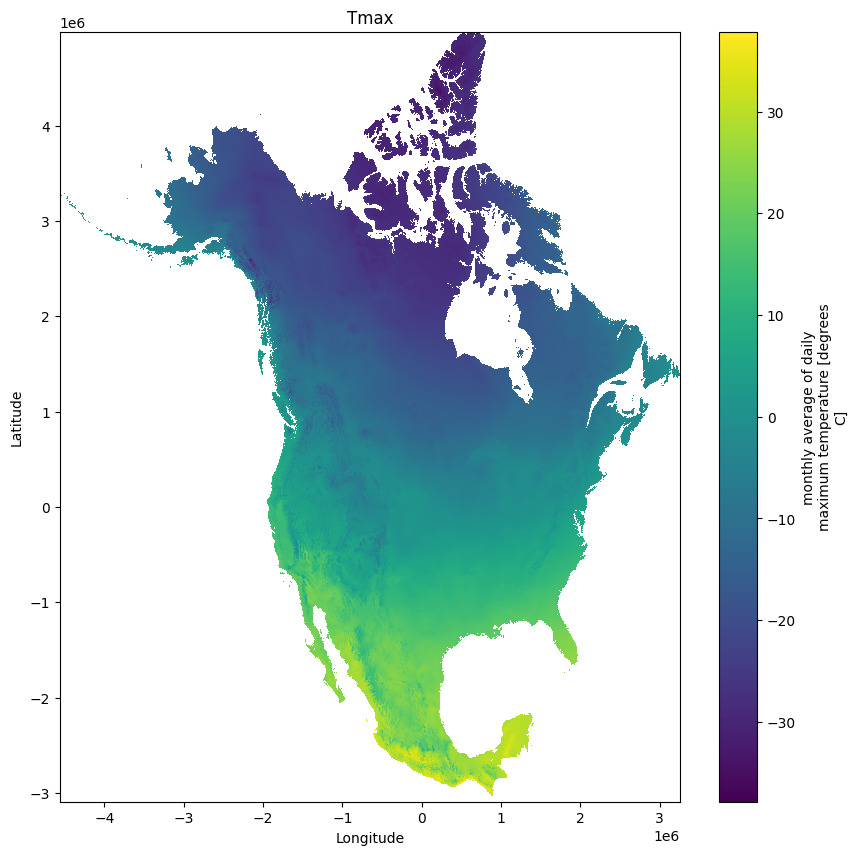

In [10]:
# Check if any datasets are loaded
if len(datasets) > 0:
    # Select the first dataset
    ds = datasets[0]

    # Print dataset information to help identify spatial dimensions and variables
    print(ds)

    # Set the spatial dimensions of the dataset
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

    # Set the coordinate reference system (CRS) of the dataset
    ds = ds.rio.write_crs("epsg:4326", inplace=True)

    # Identify the variable to plot based on user's selection
    var_to_plot = selected_option.split('/')[-1].split('_')[0]

    # Check if the variable exists in the dataset
    if var_to_plot in ds:
        # Plot the data
        fig, ax = plt.subplots(figsize=(10, 10))
        ds[var_to_plot].isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
        plt.title(var_to_plot.capitalize())
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print(f"The variable '{var_to_plot}' is not found in the dataset.")
else:
    print("No datasets are loaded.")


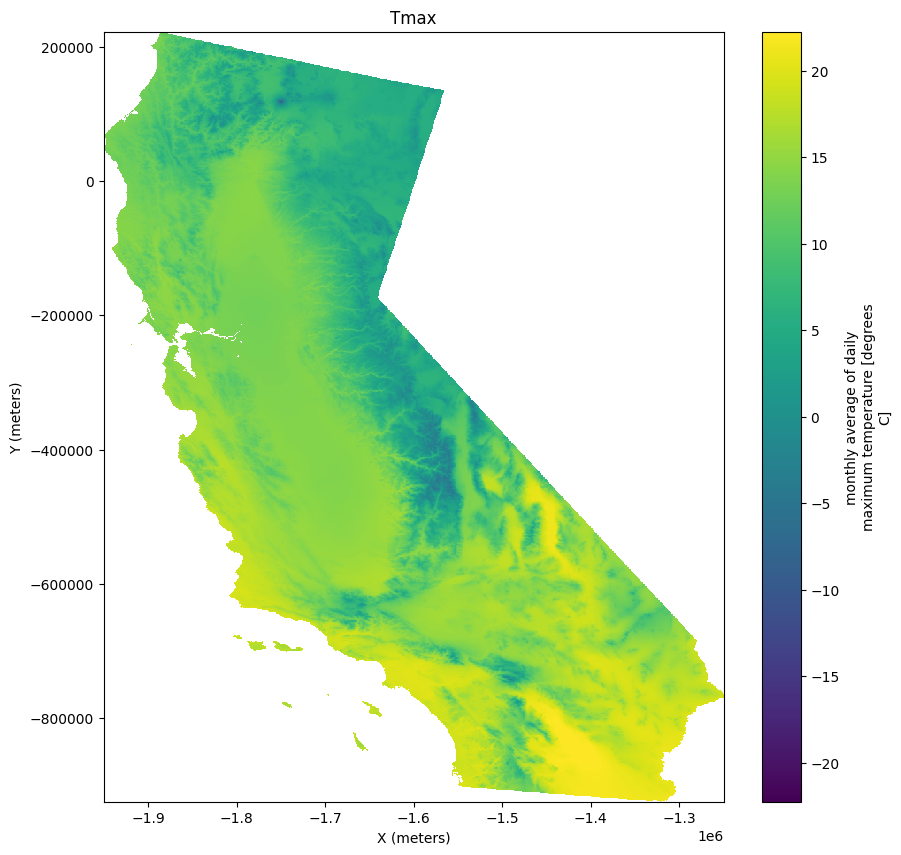

In [12]:
# Define the Daymet CRS using the Proj4 string
daymet_crs = pyproj.CRS.from_proj4("+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
# Based on this info: https://daymet.ornl.gov/overview

# Transform the shapefile to the Daymet CRS
bounding_shapefile = bounding_shapefile.to_crs(daymet_crs.to_string())

# Check if any datasets are loaded
if len(datasets) > 0:
    # Select the first dataset
    ds = datasets[0]

    # Set the spatial dimensions of the dataset
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

    # Set the coordinate reference system (CRS) of the dataset
    ds = ds.rio.write_crs(daymet_crs.to_string(), inplace=True)

    # Identify the variable to plot based on user's selection
    var_to_plot = selected_option.split('/')[-1].split('_')[0]

    # Check if the variable exists in the dataset
    if var_to_plot in ds:
        # Clip the data
        clipped = ds[var_to_plot].rio.clip(bounding_shapefile.geometry.apply(mapping), bounding_shapefile.crs, drop=True, invert=False)

        # Plot the data
        fig, ax = plt.subplots(figsize=(10, 10))
        clipped.isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
        plt.title(var_to_plot.capitalize())
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')
        plt.show()
    else:
        print(f"The variable '{var_to_plot}' is not found in the dataset.")
else:
    print("No datasets are loaded.")


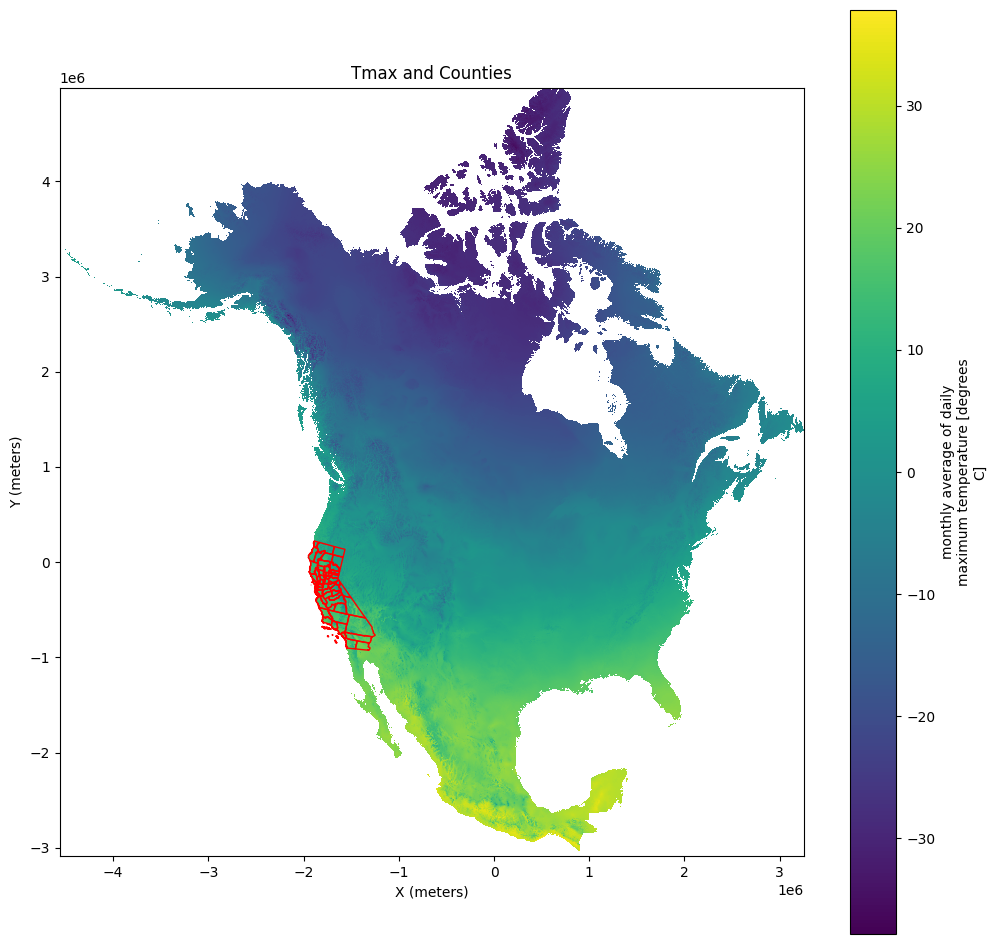

In [23]:
counties_shapefile = counties_shapefile.to_crs(daymet_crs)
fig, ax = plt.subplots(figsize=(12, 12))
ds[var_to_plot].isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
counties_shapefile.boundary.plot(ax=ax, edgecolor='red', linewidth=1)
plt.title(f'{var_to_plot.capitalize()} and Counties')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')
plt.show()


<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


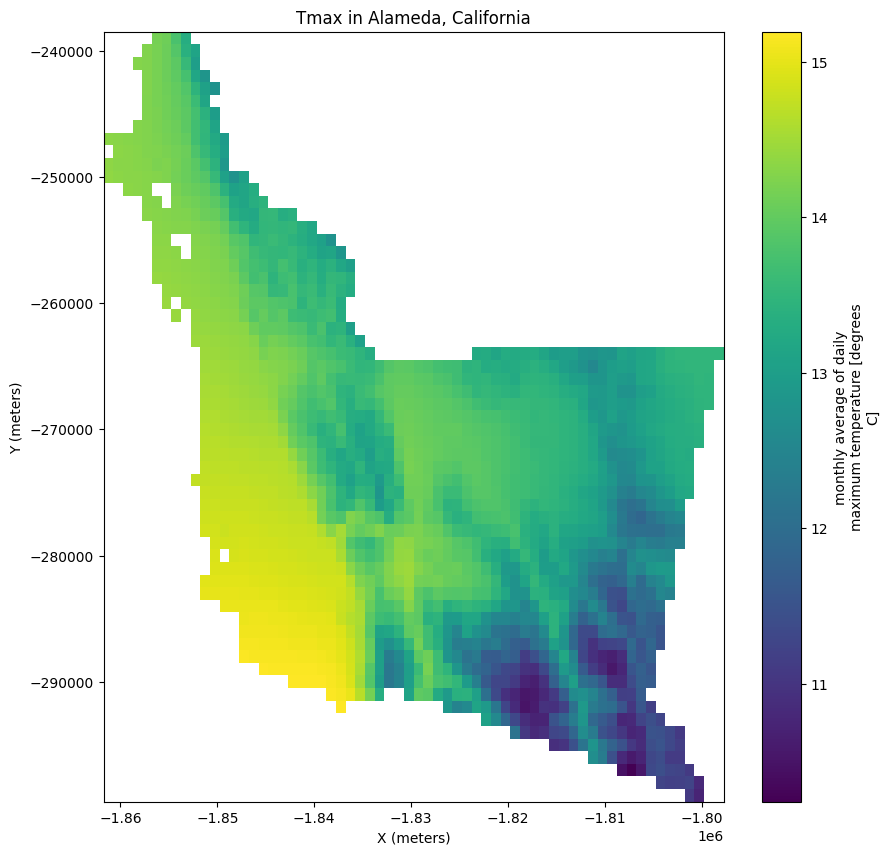

<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


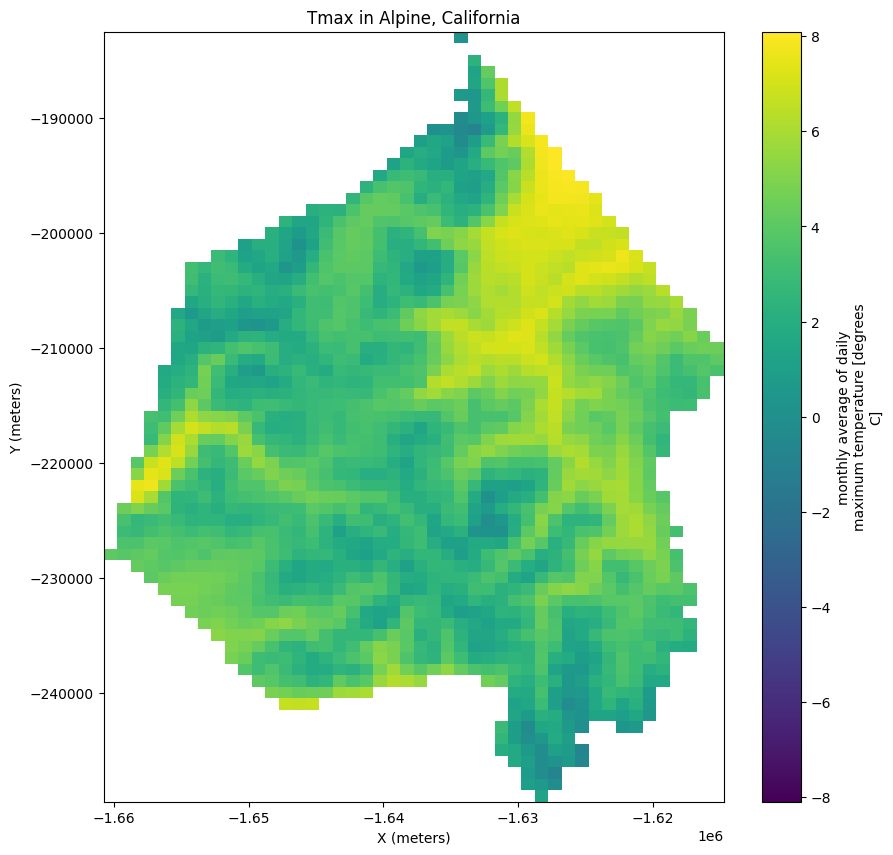

<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


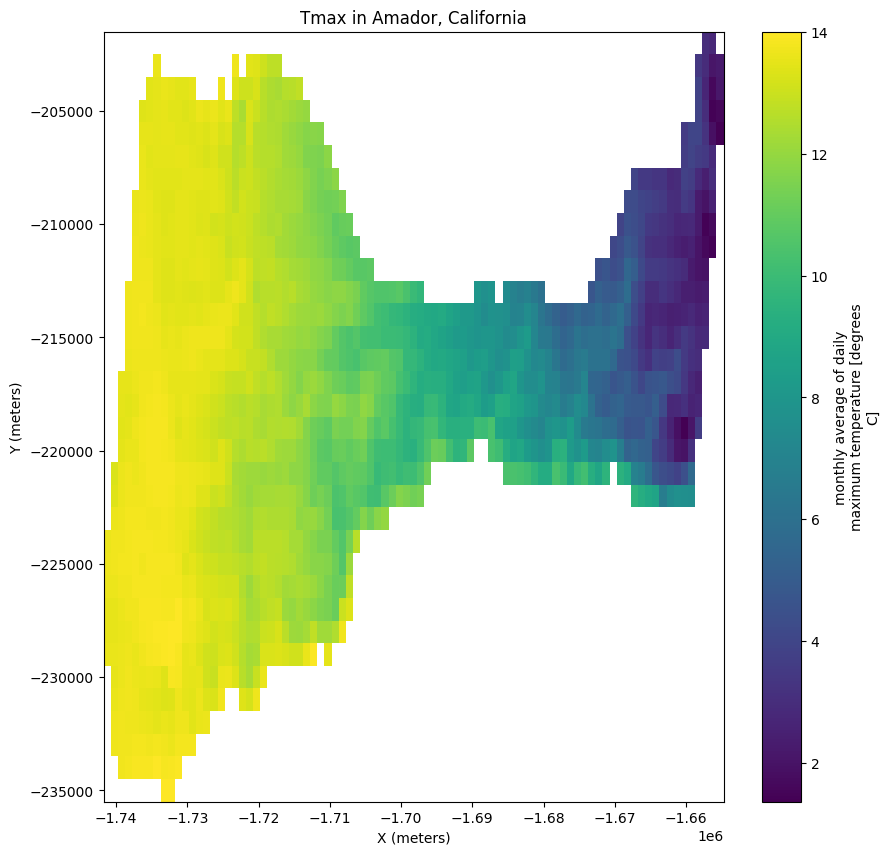

<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


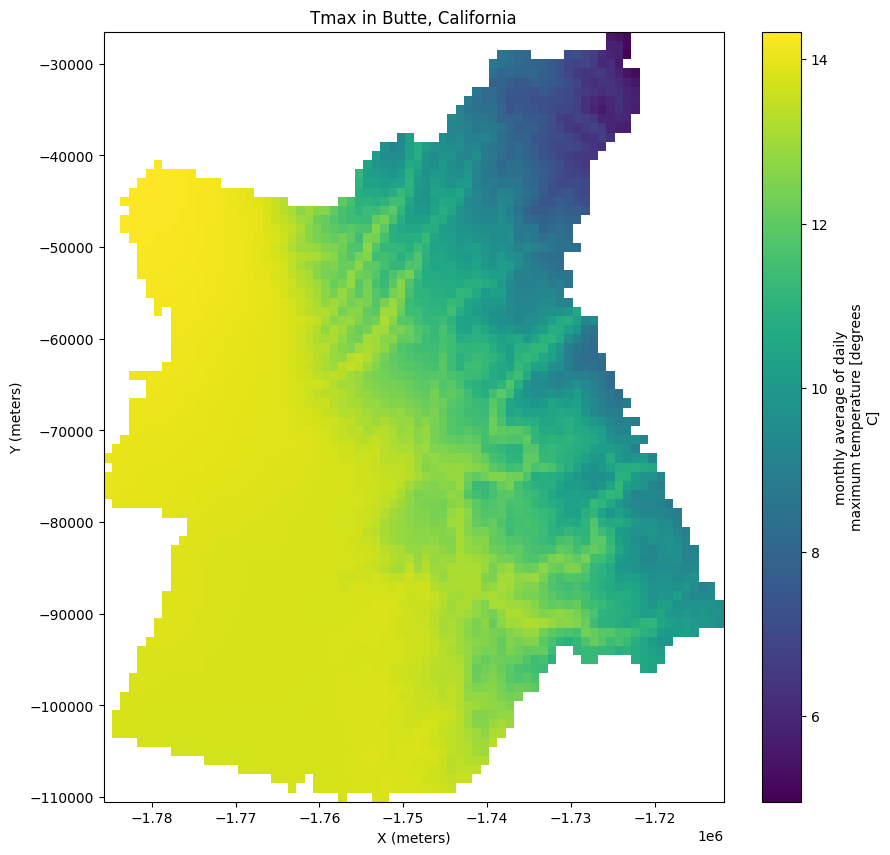

<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


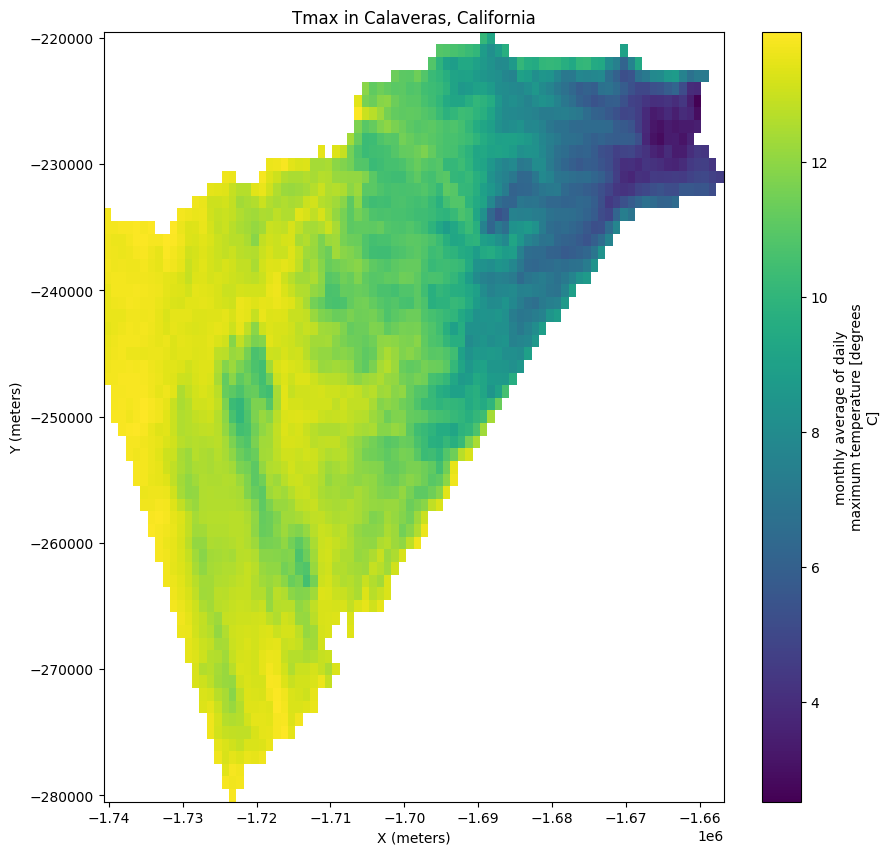

<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


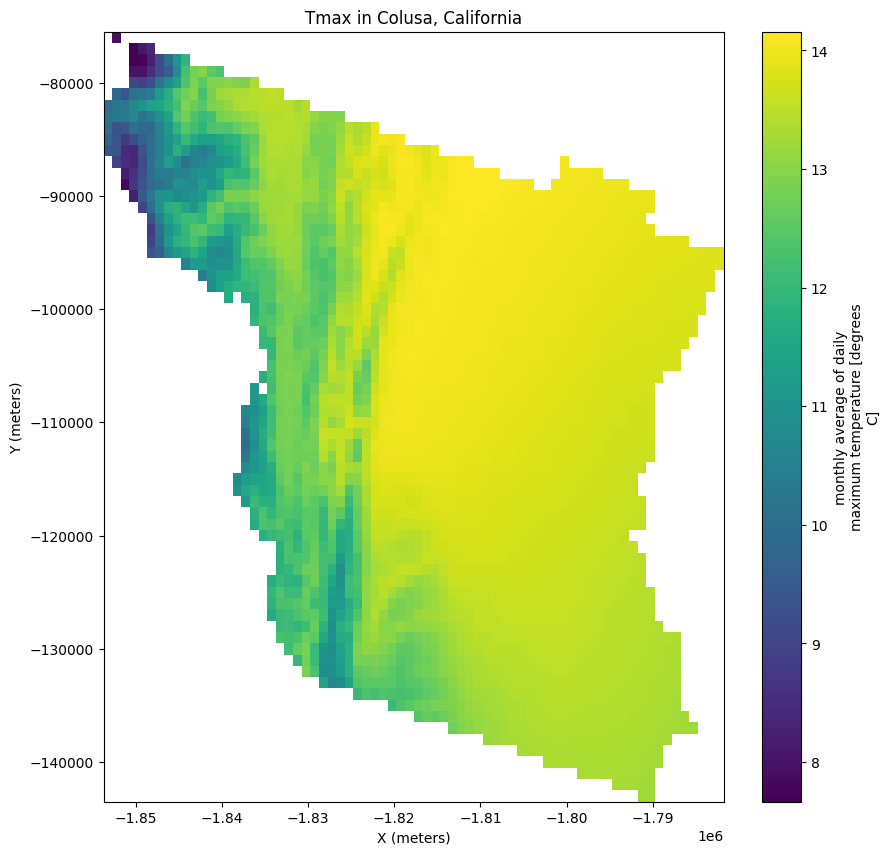

<ipython-input-24-906cfb04525b>:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


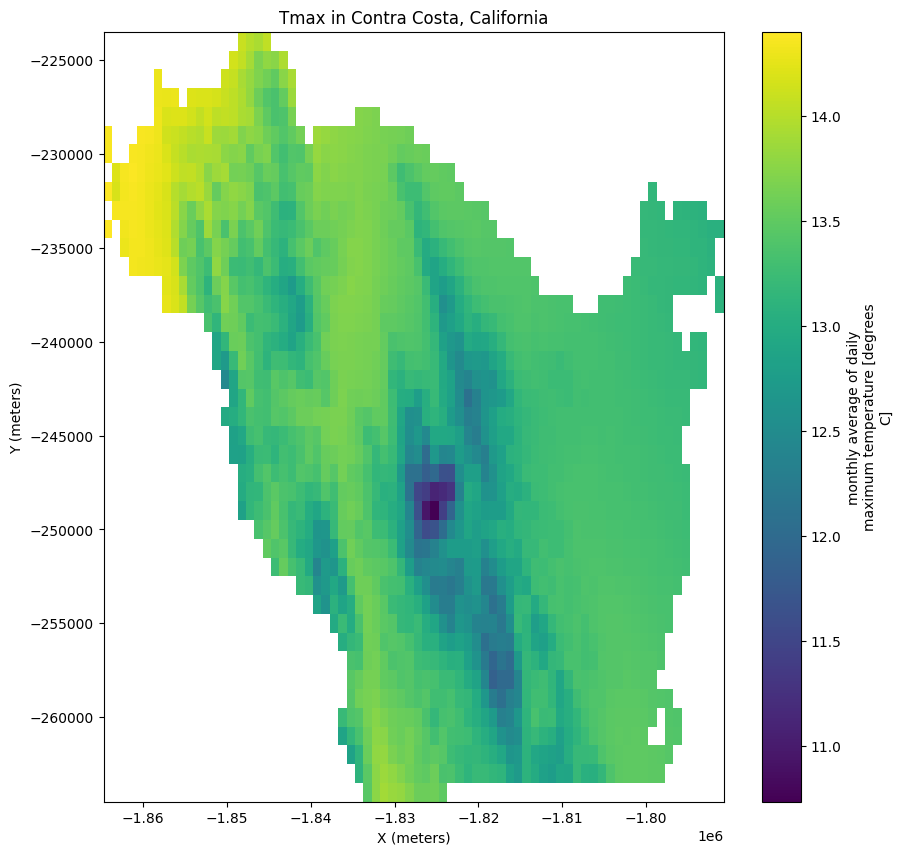

KeyboardInterrupt: ignored

In [24]:
# Transform the counties shapefile to the Daymet CRS
counties_shapefile = counties_shapefile.to_crs(daymet_crs)

# Check if any datasets are loaded
if len(datasets) > 0:
    # Select the first dataset
    ds = datasets[0]

    # Set the spatial dimensions of the dataset
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

    # Set the coordinate reference system (CRS) of the dataset
    ds = ds.rio.write_crs(daymet_crs.to_string(), inplace=True)

    # Identify the variable to plot based on user's selection
    var_to_plot = selected_option.split('/')[-1].split('_')[0]

    # Check if the variable exists in the dataset
    if var_to_plot in ds:
        # Initialize a DataFrame to store the results
        results_df = pd.DataFrame(columns=['State', 'County', var_to_plot])

        # Iterate over each county in the counties shapefile
        for idx, row in counties_shapefile.iterrows():
            # Clip the data to the current county's boundaries
            try:
                clipped = ds[var_to_plot].rio.clip([row['geometry']], ds.rio.crs, drop=True, invert=False)

                # Calculate the average value within the county
                avg_value = clipped.mean().values.item()

                # Append the results to the DataFrame
                results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 10))
                clipped.isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
                plt.title(f"{var_to_plot.capitalize()} in {row['NAME_2']}, {row['NAME_1']}")
                plt.xlabel('X (meters)')
                plt.ylabel('Y (meters)')
                plt.show()

            except rioxarray.exceptions.NoDataInBounds:
                print(f"No data found in bounds for {row['NAME_2']}, {row['NAME_1']}.")
                continue

        # Display the results DataFrame
        print(results_df)

    else:
        print(f"The variable '{var_to_plot}' is not found in the dataset.")
else:
    print("No datasets are loaded.")


<ipython-input-26-c91eb2118fef>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


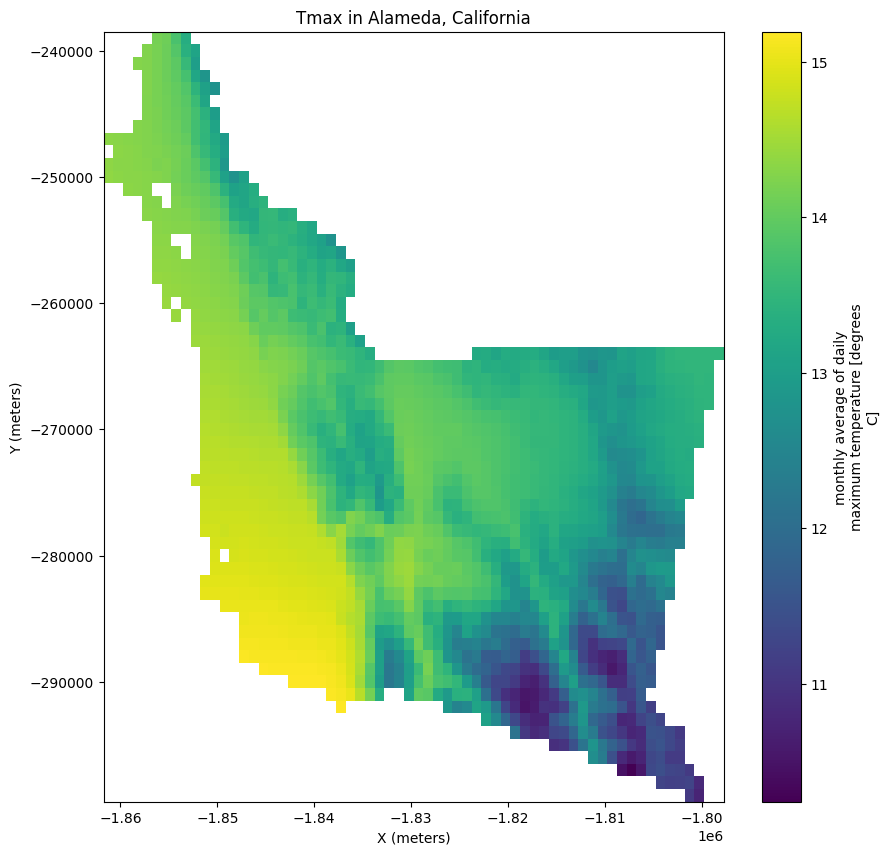

<ipython-input-26-c91eb2118fef>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


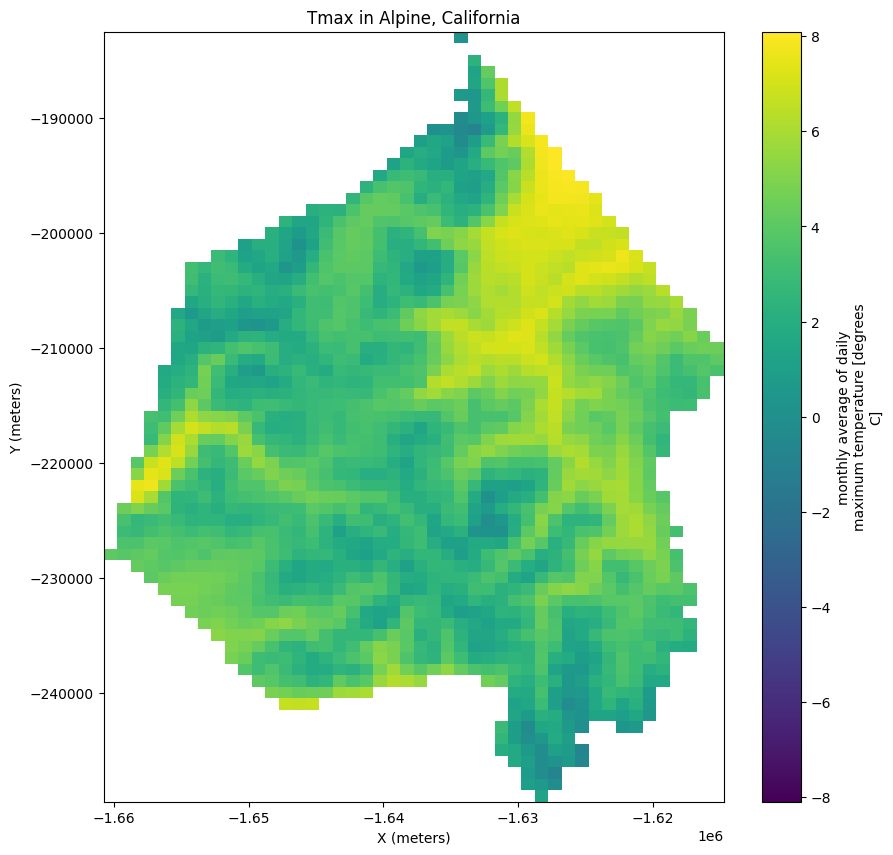

<ipython-input-26-c91eb2118fef>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)


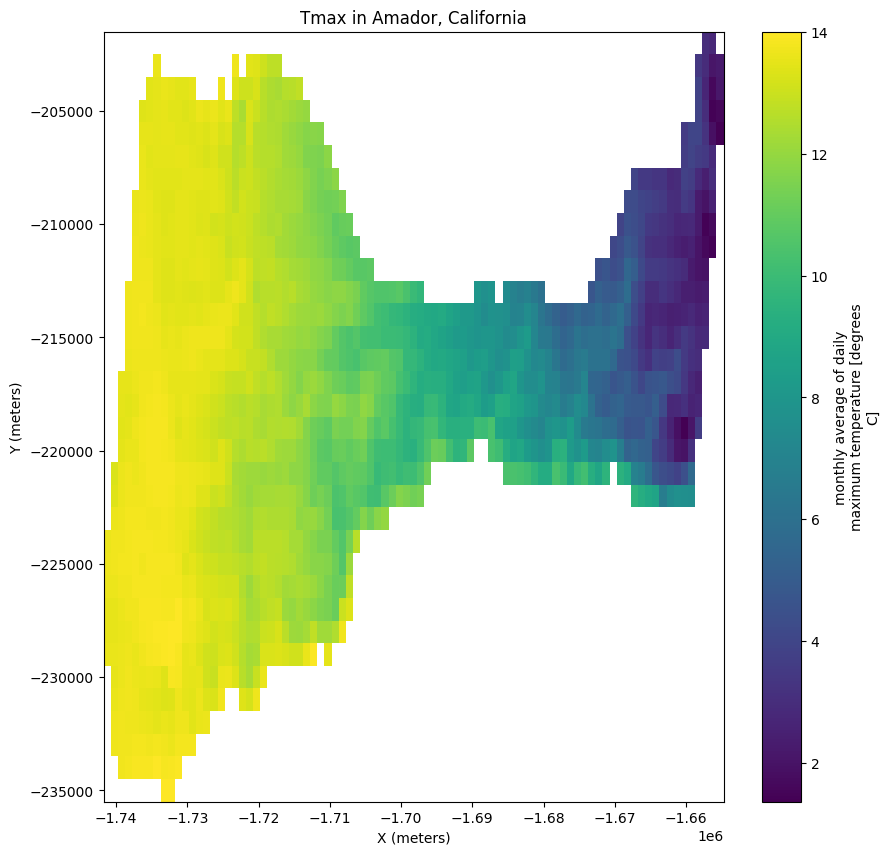

        State   County       tmax
0  California  Alameda  20.744184
1  California   Alpine  12.068288
2  California   Amador  20.266642


In [26]:
## this is just for testing to make sure it is working before going through all counties:

# Transform the counties shapefile to the Daymet CRS
counties_shapefile = counties_shapefile.to_crs(daymet_crs)

# Check if any datasets are loaded
if len(datasets) > 0:
    # Select the first dataset
    ds = datasets[0]

    # Set the spatial dimensions of the dataset
    ds = ds.rio.set_spatial_dims(x_dim='x', y_dim='y', inplace=True)

    # Set the coordinate reference system (CRS) of the dataset
    ds = ds.rio.write_crs(daymet_crs.to_string(), inplace=True)

    # Identify the variable to plot based on user's selection
    var_to_plot = selected_option.split('/')[-1].split('_')[0]

    # Check if the variable exists in the dataset
    if var_to_plot in ds:
        # Initialize a DataFrame to store the results
        results_df = pd.DataFrame(columns=['State', 'County', var_to_plot])

        # Initialize a counter for the number of counties processed
        county_count = 0

        # Iterate over each county in the counties shapefile
        for idx, row in counties_shapefile.iterrows():
            # Clip the data to the current county's boundaries
            try:
                clipped = ds[var_to_plot].rio.clip([row['geometry']], ds.rio.crs, drop=True, invert=False)

                # Calculate the average value within the county
                avg_value = clipped.mean().values.item()

                # Append the results to the DataFrame
                results_df = results_df.append({'State': row['NAME_1'], 'County': row['NAME_2'], var_to_plot: avg_value}, ignore_index=True)

                # Plot the data
                fig, ax = plt.subplots(figsize=(10, 10))
                clipped.isel(time=0).plot(ax=ax, cmap='viridis', add_colorbar=True)
                plt.title(f"{var_to_plot.capitalize()} in {row['NAME_2']}, {row['NAME_1']}")
                plt.xlabel('X (meters)')
                plt.ylabel('Y (meters)')
                plt.show()

                # Increment the county counter
                county_count += 1

                # Break the loop if 3 counties have been processed
                if county_count >= 3:
                    break

            except rioxarray.exceptions.NoDataInBounds:
                print(f"No data found in bounds for {row['NAME_2']}, {row['NAME_1']}.")
                continue

        # Display the results DataFrame
        print(results_df)

    else:
        print(f"The variable '{var_to_plot}' is not found in the dataset.")
else:
    print("No datasets are loaded.")
